## Imports

In [9]:
import torch
import torch.utils.data as Data
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms as T, models
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from transformers import get_cosine_schedule_with_warmup
from sklearn.metrics import accuracy_score, confusion_matrix
from torchsummary import summary
import seaborn as sns
from scipy.special import softmax

import warnings
warnings.filterwarnings("ignore")

In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.empty_cache()
else:
    device = torch.device('cpu')


print('using device:', device)

using device: cpu


## Reading/Processing the Data

In [12]:
data_path = '/Users/yongfengli/Downloads/plant-pathology-2020-fgvc7'

In [13]:
IMAGE_PATH = Path(data_path+'/images')

def image_path(file_stem):
    return IMAGE_PATH/f'{file_stem}.jpg'

In [14]:
train_df = pd.read_csv(data_path+'/train.csv')
test_df = pd.read_csv(data_path+'/test.csv')

train_paths = train_df['img_file'] = train_df['image_id'].apply(image_path)
test_paths = test_df['img_file'] = test_df['image_id'].apply(image_path)

train_labels = train_df[['healthy','multiple_diseases','rust','scab']]


In [15]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    train_paths, train_labels, test_size = 0.2, random_state=23, stratify = train_labels)
train_paths.reset_index(drop=True,inplace=True)
train_labels.reset_index(drop=True,inplace=True)
valid_paths.reset_index(drop=True,inplace=True)
valid_labels.reset_index(drop=True,inplace=True)

### Visualize Data

In [18]:
import cv2
import imutils
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [19]:
scab = cv2.imread(str(train_df.iloc[0]['img_file']))
multi = cv2.imread(str(train_df.iloc[1]['img_file']))
rust = cv2.imread(str(train_df.iloc[1819]['img_file']))
healthy = cv2.imread(str(train_df.iloc[4]['img_file']))
kernel = np.ones((6,6),np.float32)/25

types = [healthy, multi, rust, scab]

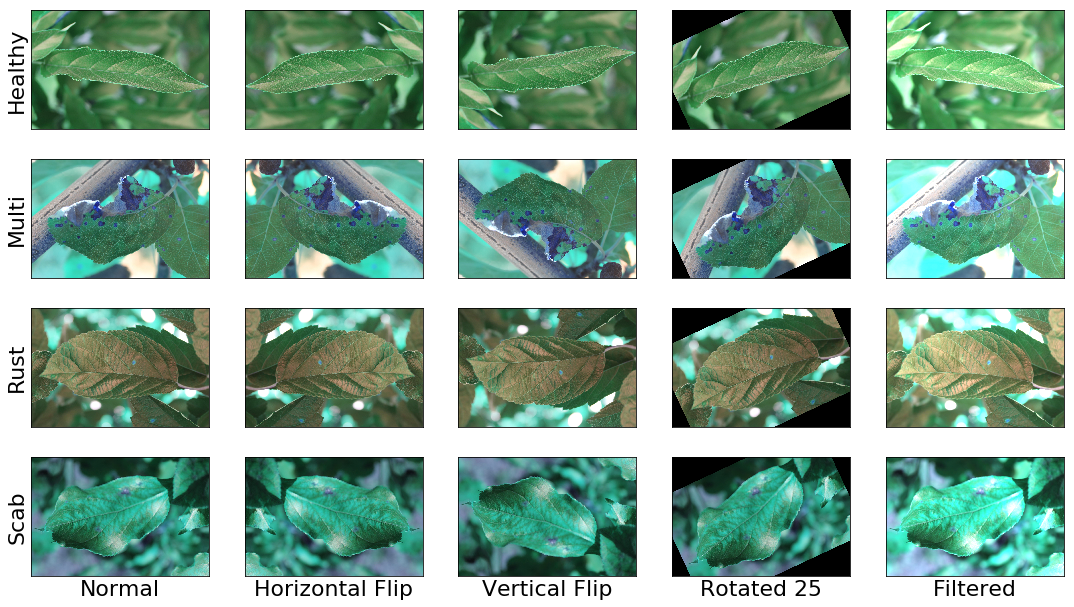

In [20]:
fig, axs = plt.subplots(4, 5)
y_labels = ['Healthy', 'Multi', 'Rust', 'Scab']
x_labels = ['Normal', 'Horizontal Flip', 'Vertical Flip', 'Rotated 25', 'Filtered']

for i in range(4):
    axs[i, 0].imshow(types[i])
    axs[i, 0].set(ylabel=y_labels[i])
    axs[i, 1].imshow(cv2.flip(types[i], 1))
    axs[i, 2].imshow(cv2.flip(types[i], 0))
    axs[i, 3].imshow(imutils.rotate(types[i], 25))
    axs[i, 4].imshow(cv2.filter2D(types[i],-1,kernel))
    
    if (i + 1) == 4:
        for j in range(5):
            axs[i, j].set(xlabel=x_labels[j])
    

for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

        
fig.set_size_inches(18.5, 10.5)
fig.savefig('example.jpg')

### Creating a custom dataset object

In [21]:
class LeafDataset(Data.Dataset):
    def __init__(self, img_paths, labels=None, train=True, test=False):
        self.img_paths = img_paths
        self.train = train
        self.test = test
        
        if not self.test:
            self.labels = labels
        
        self.train_transform = T.Compose([T.RandomRotation(25),
                                          T.RandomHorizontalFlip(),
                                          T.RandomVerticalFlip(),])
        self.test_transform = T.Compose([T.RandomRotation(25),
                                         T.RandomHorizontalFlip(),
                                         T.RandomVerticalFlip(),])
        self.default_transform = T.Compose([T.ToTensor(),
                                            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),]) # ImageNet Stats
        
    def __len__(self):
        return self.img_paths.shape[0]
    
    
    def __getitem__(self, i):
        image = Image.open(self.img_paths[i]).resize((512, 512))
        if not self.test:
            label = torch.tensor(np.argmax(self.labels.loc[i, :].values))
        
        if self.train:
            image = self.train_transform(image)
        elif self.test:
            image = self.test_transform(image)
        image  = self.default_transform(image)
        
        if self.test:
            return image
        
        return image, label

### Define training, validataion and testing functions

In [22]:
def training(model, data_loader, optim, scheduler, loss_fn, acc_fn):
    running_loss = 0
    preds_for_acc = []
    labels_for_acc = []
    
    pbar = tqdm(total=len(data_loader), desc='Training')
    
    for idx, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        model.train()
        optim.zero_grad()
        scores = model(images)
        loss = loss_fn(scores, labels)
        loss.backward()
        optim.step()
        scheduler.step()
        
        running_loss += loss.item() * labels.shape[0]
        labels_for_acc = np.concatenate((labels_for_acc, labels.cpu().numpy()), 0)
        preds_for_acc = np.concatenate(
            (preds_for_acc, np.argmax(scores.cpu().detach().numpy(), 1)), 0)
        
        pbar.update()
    
    pbar.close()
    
    return running_loss / TRAIN_SIZE, acc_fn(labels_for_acc, preds_for_acc)


def validation(model, data_loader, loss_fn, acc_fn, confusion_matrix):
     
    running_loss = 0
    preds_for_acc = []
    labels_for_acc = []
    
    pbar = tqdm(total = len(data_loader), desc='Validation')
    
    with torch.no_grad():       #torch.no_grad() prevents Autograd engine from storing intermediate values, saving memory
        for idx, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device)
            model.eval()
            scores = model(images)
            loss = loss_fn(scores, labels)
            
            running_loss += loss.item() * labels.shape[0]
            labels_for_acc = np.concatenate((labels_for_acc, labels.cpu().numpy()), 0)
            preds_for_acc = np.concatenate((preds_for_acc, np.argmax(scores.cpu().detach().numpy(), 1)), 0)
            
            pbar.update()
            
        accuracy = acc_fn(labels_for_acc, preds_for_acc)
        conf_mat = confusion_matrix(labels_for_acc, preds_for_acc)
    
    pbar.close()
    return running_loss/VALID_SIZE, accuracy, conf_mat


def testing(model, data_loader):
    
    preds_for_output = np.zeros((1,4))
    
    with torch.no_grad():
        pbar = tqdm(total = len(data_loader))
        for _, images in enumerate(data_loader):
            images = images.to(device)
            model.eval()
            scores = model(images)
            preds_for_output = np.concatenate((preds_for_output, scores.cpu().detach().numpy()), 0)
            pbar.update()
    
    pbar.close()
    return preds_for_output

### Initialization

In [23]:
BATCH_SIZE = 8
NUM_EPOCHS = 30
TRAIN_SIZE = train_labels.shape[0]
VALID_SIZE = valid_labels.shape[0]

In [24]:
train_dataset = LeafDataset(train_paths, train_labels)
trainloader = Data.DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE, num_workers = 2)

valid_dataset = LeafDataset(valid_paths, valid_labels, train = False)
validloader = Data.DataLoader(valid_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = 2)

test_dataset = LeafDataset(test_paths,train = False, test = True)
testloader = Data.DataLoader(test_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = 2)

#### Please only run one of the net sections before running the training loop

### DenseNet

In [30]:
densenet = models.densenet161(pretrained=True)
model = densenet

In [31]:
num_filters = densenet.classifier.in_features
densenet.classifier = nn.Sequential(
    nn.Linear(num_filters, train_labels.shape[1])
)

In [32]:
optimizer = torch.optim.Adam(densenet.parameters(), lr=8e-4, weight_decay = 1e-3)
num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=len(train_dataset)/BATCH_SIZE*5, num_training_steps=num_train_steps)
loss_fn = torch.nn.CrossEntropyLoss()

### ResNet

In [28]:
resnet18 = models.resnet18(pretrained=True)
num_filters = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_filters, train_labels.shape[1])
model = resnet18

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/yongfengli/.cache/torch/checkpoints/resnet18-5c106cde.pth
100.0%


In [29]:
optimizer = torch.optim.Adam(densenet.parameters(), lr=8e-4, weight_decay = 1e-3)
num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=len(train_dataset)/BATCH_SIZE*5, num_training_steps=num_train_steps)
loss_fn = torch.nn.CrossEntropyLoss()

### Inception

In [ ]:
inception = models.inception_v3(pretrained=True)

In [ ]:
optimizer = torch.optim.Adam(densenet.parameters(), lr=8e-4, weight_decay = 1e-3)
num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
scheduler = get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps=len(train_dataset)/BATCH_SIZE*5, num_training_steps=num_train_steps)
loss_fn = torch.nn.CrossEntropyLoss()

### Training loop

In [33]:
train_loss = []
valid_loss = []
train_acc = []
val_acc = []

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [34]:
for epoch in range(NUM_EPOCHS):
    
    tl, ta = training(model, trainloader, optimizer, scheduler, loss_fn, accuracy_score)
    vl, va, conf_mat = validation(model, validloader, loss_fn, accuracy_score, confusion_matrix)
    train_loss.append(tl)
    valid_loss.append(vl)
    train_acc.append(ta)
    val_acc.append(va)
    
    if (epoch+1)%10==0:
        checkpoint = Path('model_checkpoints/')
        checkpoint.mkdir(exist_ok=True)
        torch.save(model.state_dict(), checkpoint/f'epoch_{epoch}.pt')
    
    printstr = 'Epoch: '+ str(epoch) + ', Train loss: ' + str(tl) + ', Val loss: ' + str(vl) + ', Train acc: ' + str(ta) + ', Val acc: ' + str(va)
    tqdm.write(printstr)
    

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 200, in send_by

KeyboardInterrupt: 

### Plots

In [ ]:
plt.figure()
plt.ylim(0,1.5)
sns.lineplot(list(range(len(train_loss))), train_loss)
sns.lineplot(list(range(len(valid_loss))), valid_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])

In [ ]:
plt.figure()
sns.lineplot(list(range(len(train_acc))), train_acc)
sns.lineplot(list(range(len(val_acc))), val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])

In [ ]:
labels = ['Healthy', 'Multiple','Rust','Scab']
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)

### Testing Performance

In [ ]:
subs = []
for i in range(5): #average over 5 runs
    out = testing(model, testloader)
    output = pd.DataFrame(softmax(out,1), columns = ['healthy','multiple_diseases','rust','scab']) #the submission expects probability scores for each class
    output.drop(0, inplace = True)
    output.reset_index(drop=True,inplace=True)
    subs.append(output)

sub_eff1 = sum(subs)/5

### Model Emsembling